In [24]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 7.6 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633757 sha256=adb49bab5debb264cb3360f32118f29855f4193d51ad004485ba3eff9c3bd61f
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [10]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from surprise import KNNWithMeans
from surprise.model_selection import cross_validate
from scipy._lib.six import b
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import pairwise_distances 


In [11]:
train = pd.read_csv('reco_assignment_training.csv')
holdout = pd.read_csv('reco_assignment_holdout.csv')

In [12]:
train.head()

Customer_num     Tran_dt Product_num  Tran_qty
0     C_203152  2022-01-02      P_3365     0.135
1    C_1607154  2022-01-02        P_58     1.000
2      C_84518  2022-01-02     P_21295     1.000
3    C_2553711  2022-01-02     P_20576     1.000
4    C_2376922  2022-01-02      P_1095     2.000

#EDA

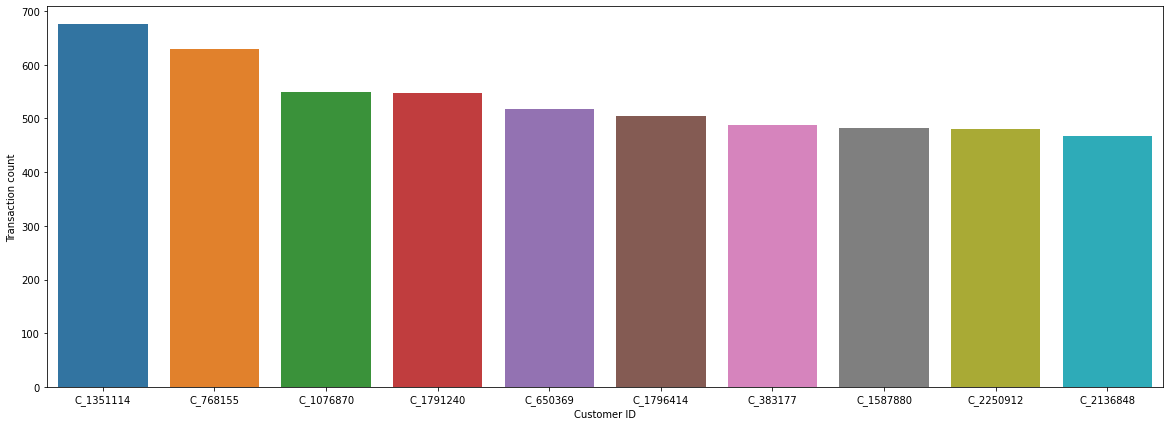

In [13]:
#top 10 customers who did max transactions
temp = train['Customer_num'].value_counts().reset_index().sort_values(
    by='Customer_num', ascending=False)
temp = temp[:10]
temp.columns = ['Customer ID', 'Transaction count']

fig, ax = plt.subplots(figsize=(20, 7))
ax = sns.barplot(x="Customer ID", y="Transaction count", data=temp, ax=ax)

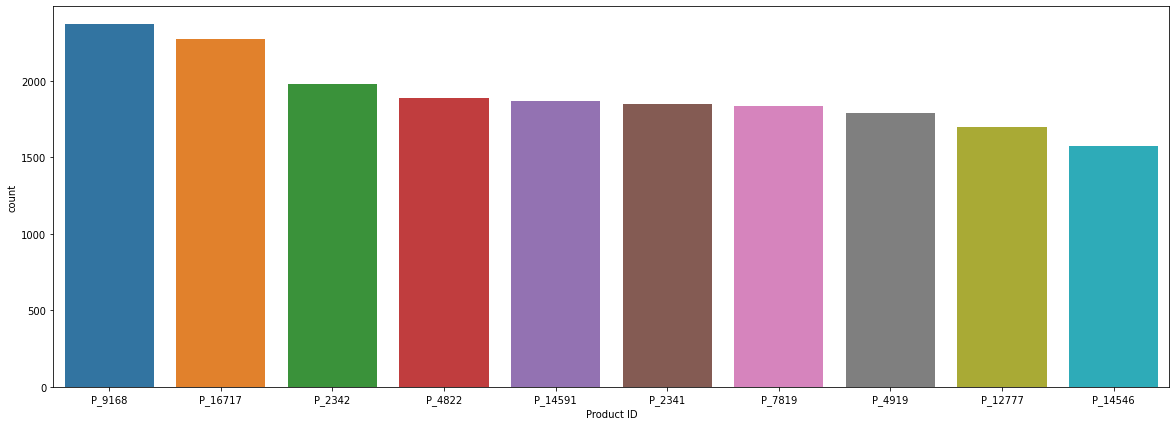

In [14]:
#top 10 products 
temp = train['Product_num'].value_counts().reset_index().sort_values(
    by='Product_num', ascending=False)
temp = temp[:10]
temp.columns = ['Product ID', 'count']

fig, ax = plt.subplots(figsize=(20, 7))
ax = sns.barplot(x="Product ID", y="count", data=temp, ax=ax)

#Q1
####Next 3 products to be purchased by each customer

In [15]:
#drop missing values
train.dropna(axis=0, inplace=True)

customer_mapping = {k:v for v,k in enumerate(list(train.Customer_num.unique()))}
product_mapping = {k:v for v,k in enumerate(list(train.Product_num.unique()))}

n_users = train.Customer_num.unique().shape[0]
n_items = train.Product_num.unique().shape[0]

UI_collab = np.zeros((n_users, n_items))


for line in train.itertuples():
    cust = customer_mapping[line[1]]
    prod = product_mapping[line[3]]
    UI_collab[cust,prod] = line[4]

#convert sparse to dense
csr_sample = csr_matrix(UI_collab)

knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=7, 
                           n_jobs=-1)
knn.fit(csr_sample)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=7)

In [18]:
cust_ID = list(train.Customer_num.unique())


In [ ]:
#Next 3 products to be purchased by each customer
import operator

dataset_sort_des = train.sort_values(['Customer_num', 'Tran_dt'], 
                                     ascending=[True, False])

recommended_products_to_customer = []
product_mapping_rev = {v:k for k,v in product_mapping.items()}

for cust in cust_ID:
  filter1 = dataset_sort_des[dataset_sort_des['Customer_num'] == cust].Product_num
  filter1 = filter1.tolist()
  filter1 = filter1[:31]

  recommended_products = {}

  try:
    for i in filter1:
        distances , indices = knn.kneighbors(csr_sample[product_mapping[i]],
                                            n_neighbors=7)
        distances = distances[0]
        indices = indices[0]

        indices= indices.flatten()[1:]
        prods = []

        for idx,dist in zip(indices, distances):
          
          prod = product_mapping_rev[idx]
          if prod in recommended_products:
            recommended_products[prod] = min(dist, recommended_products[prod])
          else:
            recommended_products[prod] = dist
    recommended_products = list(dict(sorted(recommended_products.items(), 
                                       key=operator.itemgetter(1))).keys())[:3]

    recommended_products_to_customer.append(recommended_products)
    print("Items to be recommended to customer {} = : {}".format(cust, 
                                                    recommended_products))
  except:
    pass

Items to be recommended to customer C_203152 = : ['P_3177', 'P_36800', 'P_15002']
Items to be recommended to customer C_2553711 = : ['P_925', 'P_1298', 'P_3716']
Items to be recommended to customer C_1795098 = : ['P_16164', 'P_25420', 'P_44288']
Items to be recommended to customer C_213447 = : ['P_3285', 'P_30564', 'P_37318']
Items to be recommended to customer C_1753813 = : ['P_31392', 'P_4051', 'P_17948']
Items to be recommended to customer C_349594 = : ['P_23004', 'P_7021', 'P_38276']
Items to be recommended to customer C_1637731 = : ['P_44387', 'P_9722', 'P_9504']
Items to be recommended to customer C_1079459 = : ['P_915', 'P_12271', 'P_17302']
Items to be recommended to customer C_729802 = : ['P_17768', 'P_41885', 'P_1879']
Items to be recommended to customer C_2108498 = : ['P_3003', 'P_17722', 'P_12816']
Items to be recommended to customer C_959780 = : ['P_1187', 'P_6401', 'P_31561']
Items to be recommended to customer C_612767 = : ['P_33690', 'P_6767', 'P_25429']
Items to be rec

#Q2: Top 5 similar customers to each customer

In [8]:
from numpy import dot
from numpy.linalg import norm
import operator

def most_similar_users(target_person, subject):
    cos_sim = dot(target_person, subject)/(norm(target_person)*norm(subject))
    return cos_sim

In [16]:
uu_based = train.groupby(['Customer_num', 'Product_num']).size().reset_index(name='counts')

n_users = list(uu_based.Customer_num.unique())
n_items = list(uu_based.Product_num.unique())

B = np.zeros((len(n_users), len(n_items)))

customer_mapping = {k:v for v,k in enumerate(n_users)}
product_mapping = {k:v for v,k in enumerate(n_items)}


for line in uu_based.itertuples():
    cust = customer_mapping[line[1]]
    prod = product_mapping[line[2]]
    B[cust, prod] += 1

dataset = pd.DataFrame(B, columns=list(uu_based.Product_num.unique()))
dataset.index = list(uu_based.Customer_num.unique())
dataset = dataset.T

In [ ]:
similar_customers = []

for cust in cust_ID:

  scores = dict()
  for cust1 in cust_ID:
    if cust != cust1:
      a = dataset[cust]
      b = dataset[cust1]

      scores[cust1] = most_similar_users(a, b)

  scores = list(dict(sorted(scores.items(), 
                          key=operator.itemgetter(1), reverse=True)).keys())[:5]

  similar_customers.append(scores)

  print("similar customers = {} to customer ID = :  {}".format(scores, cust))

similar customers = ['C_1910823', 'C_2168910', 'C_875883', 'C_1310627', 'C_2109053'] to customer ID = :  C_203152
similar customers = ['C_371180', 'C_95808', 'C_1319866', 'C_1616695', 'C_1378654'] to customer ID = :  C_1607154
similar customers = ['C_564338', 'C_2178275', 'C_562762', 'C_1206732', 'C_2356993'] to customer ID = :  C_84518
similar customers = ['C_622275', 'C_2019106', 'C_2136848', 'C_29147', 'C_1808977'] to customer ID = :  C_2553711
similar customers = ['C_1109079', 'C_1478611', 'C_2221298', 'C_2213061', 'C_1554885'] to customer ID = :  C_2376922
similar customers = ['C_366553', 'C_190056', 'C_2143685', 'C_148746', 'C_469142'] to customer ID = :  C_1795098
similar customers = ['C_497354', 'C_852820', 'C_2483930', 'C_1352311', 'C_444823'] to customer ID = :  C_2559064
similar customers = ['C_116274', 'C_192949', 'C_1751905', 'C_1880281', 'C_1910823'] to customer ID = :  C_711544
similar customers = ['C_1935521', 'C_2216044', 'C_588384', 'C_1478342', 'C_2483930'] to custom

#Q3 Recall calculation on the basis of the shared holdout set

In [20]:
holdout.head()

Customer_num     Tran_dt Product_num  Tran_qty
0    C_1967485  2022-04-01      P_4321       1.0
1      C_62367  2022-04-01     P_11092       1.0
2    C_2459818  2022-04-01     P_12854       1.0
3     C_851377  2022-04-01      P_9160       1.0
4    C_2351826  2022-04-01     P_17207       1.0

In [ ]:
performance = 0

for cust,recommended in zip(cust_ID, recommended_products_to_customer):

  print(cust)
  count = 0
  try:
    temp = holdout[holdout['Customer_num'] == cust]
    temp.sort_values(by=['Tran_dt'], ascending=True)
    temp = temp['Product_num'].to_list()
    
    for i in recommended:
      if i in temp:
        count += 1
    performance += (count/3)

  except:
    pass

performance = (performance/len(cust_ID))*100